# Neural Network classifcation

Classification problems involve predicting what class a particular 'point' belongs to, there are different types of classifcation problems such as 

* binary classifcation - 2 options
* multi-class classification - multiple options
* multi-label classifcaiton - can be assigned more then one option

We will look through at using PyTorch to create neural networks for classificaiton.


## Architecture of classification neural networks

Before we look at creating our own neural networks we will first look at general architectures.

A general neural network contains (or uses) : 
* An input layer - of shape number of input features
* hidden layer(s) - amount is problem specific
* neurons per hidden layer - problem specific, normally betweewn 10 and 512
* output layer shape - 1 for binary, 1 per class for multiclass
* hidden layer activations - Usually ReLU but many other valid options
* ouput activation - Sigmoid for binary , softmax for mutliclass
* Loss function - binary cross entropy or just cross entropy
* Optimiser - usally SGD or Adam

Ofcourse the options of loss function, optimiser and so on can be changed depending on the type of question and depending on the metrics wanted.

## Making and preparing classification data

Let begin by making some data.

Here we will use sklearns make_circles to generate 2 circles and plot them for visulation.

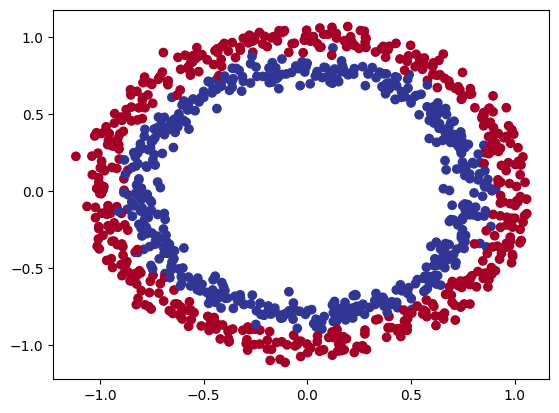

In [1]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
# Define a number of data points
N_SAMPLES = 1000

# Generate circles
X, y = make_circles(N_SAMPLES, noise = 0.05, random_state = 42)

# Visualize with a plot

plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

Next we will convert our data to tensors to avoid data type mismatches when building the NN and also split our data into training and testing data.

In [2]:
import torch
from sklearn.model_selection import train_test_split

device  = 'cuda'

X_ten = torch.from_numpy(X).type(torch.float).to(device)
y_ten = torch.from_numpy(y).type(torch.float).to(device)


X_train, X_test, y_train, y_test = train_test_split(X_ten, y_ten , train_size = 0.8, random_state= 42)

print(X_train.shape)

torch.Size([800, 2])


## Building a model

Now we have some data it is time to build a model and we will break it down into parts
* Setting up device (i already did that)
* Constructing a model by subclassing nn.Module
* Defining a loss function and optimiser
* Creating a training loop

We will want a model that takes 2 inputs (2D circles) and has 1 output (binary classifcation), first we will create a simple model of 1 hidden layer.

In [3]:
class CircleModelV0(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = torch.nn.Linear(in_features= 2, out_features=  5)
        self.layer2 = torch.nn.Linear(in_features = 5, out_features = 1)

    def forward(self, X : torch.Tensor) -> torch.Tensor:
        return self.layer2(self.layer1(X))
    
modelV0 = CircleModelV0().to(device)

The model we have create above is a simple network consisting of 1 hideen layer consisting 5 neurons with no activation function (this is really just a linear classifer but its just an example). The above can also be build using nn.Sequential and is shown below.

In [4]:
model_0 = torch.nn.Sequential(
    torch.nn.Linear(in_features=2, out_features=5),
    torch.nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

WOW! Thats amazing and much quicker then inheriteing nn.Module why dont we just do  that?

nn.Sequential is amazing for straight-forward computations, however as the namespace suggests it always just in sequential order and so if you would like something else to happen ( like relation nn's) then we will need to inherit nn.Module.

Now that we have our model we can set up our loss and optimiser, but what chose will we use?

For classifcation problems there are 2 main ones, BCE ( binary cross entropy ) and CE (cross entropy). For BCE there are 2 main ones BCELOSS and BCEwithLOgitisLOSS. The later has a built in sigmoid output activation and the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) states it is more numerically stable then BCE with a sigmoid layer on the network.

For this model we will use BCEwithLogitsLoss and a SGD optimiser.

In [5]:
loss_fn_model_v0 = torch.nn.BCEWithLogitsLoss()

optimiser = torch.optim.SGD(params = modelV0.parameters(), lr = 0.1)

Before we can train our model we will create an evaluation metric, this can be used to give a perspective of how our model is performing and for this we will use accuracy (what % are correctly identified).

In [6]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

## Training the model

Now that we have loss function and optimiser defined we can train our model. Since we are using a linear layer with a sigmoid activation on the output (built into the loss function) our outputs will be in the range [0, 1] and can be interpreted as the chance of it being either 0, 1 with closer to 0 being a confident prediction it it class 0 and closer to 1 being a confident prediction its 1.

In [7]:
# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device).squeeze()
X_test, y_test = X_test.to(device), y_test.to(device).squeeze()


# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    modelV0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = modelV0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)).squeeze() # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn_model_v0(y_logits, 
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimiser.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimiser.step()

    ### Testing
    modelV0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = modelV0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn_model_v0(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69882, Accuracy: 48.75% | Test loss: 0.70503, Test acc: 48.50%
Epoch: 10 | Loss: 0.69674, Accuracy: 49.12% | Test loss: 0.70231, Test acc: 48.50%
Epoch: 20 | Loss: 0.69584, Accuracy: 49.38% | Test loss: 0.70091, Test acc: 49.50%
Epoch: 30 | Loss: 0.69537, Accuracy: 50.62% | Test loss: 0.70006, Test acc: 49.00%
Epoch: 40 | Loss: 0.69508, Accuracy: 50.75% | Test loss: 0.69946, Test acc: 48.50%
Epoch: 50 | Loss: 0.69485, Accuracy: 50.88% | Test loss: 0.69901, Test acc: 49.50%
Epoch: 60 | Loss: 0.69467, Accuracy: 51.12% | Test loss: 0.69864, Test acc: 50.00%
Epoch: 70 | Loss: 0.69451, Accuracy: 51.12% | Test loss: 0.69833, Test acc: 49.00%
Epoch: 80 | Loss: 0.69438, Accuracy: 51.38% | Test loss: 0.69805, Test acc: 49.00%
Epoch: 90 | Loss: 0.69426, Accuracy: 51.25% | Test loss: 0.69781, Test acc: 49.00%


As we can see our model has a poor accuracy and the loss functions dont really go down that much during training.

## Making predictions and evaluating the model

From our metrics it appears as though the modeling is guessing, a better way to see why or how this is happening is to visulise the decision boundries from the model through plot_decision_boundry().

In [8]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


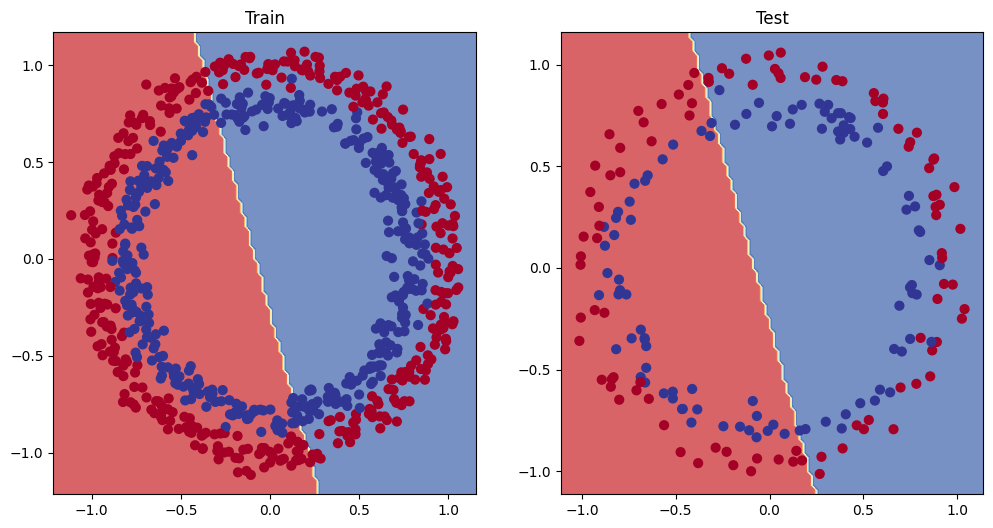

In [9]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(modelV0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(modelV0, X_test, y_test)


It appears as though our model is incapable of learning the complex nature of a circle (it is just a linear model after all) and so we need to look at improving our model so that it doesnt massively underfit the data.

## Improving a model - Adding non linearity

To improve a model we can change (or add/take away) any of the things that build our model, the main one we are missing on our model is non linearity, our current model after all is really just $$ y = mx +b $$ and so we need to add a non linear element so that it can model a circle. This can be done through adding an activation function for which we will use  ReLU (Rectified Linear Unit).

In [10]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)

optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [11]:
# Fit the model
epochs =  1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn_model_v0(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn_model_v0(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")
      

Epoch: 0 | Loss: 0.70573, Accuracy: 50.00% | Test Loss: 0.70585, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.68902, Accuracy: 63.38% | Test Loss: 0.69083, Test Accuracy: 61.00%
Epoch: 200 | Loss: 0.68520, Accuracy: 56.75% | Test Loss: 0.68810, Test Accuracy: 57.50%
Epoch: 300 | Loss: 0.67913, Accuracy: 62.00% | Test Loss: 0.68351, Test Accuracy: 62.50%
Epoch: 400 | Loss: 0.66965, Accuracy: 65.12% | Test Loss: 0.67647, Test Accuracy: 64.50%
Epoch: 500 | Loss: 0.65509, Accuracy: 70.25% | Test Loss: 0.66504, Test Accuracy: 66.50%
Epoch: 600 | Loss: 0.63058, Accuracy: 76.25% | Test Loss: 0.64604, Test Accuracy: 71.50%
Epoch: 700 | Loss: 0.58862, Accuracy: 83.88% | Test Loss: 0.61259, Test Accuracy: 83.50%
Epoch: 800 | Loss: 0.52256, Accuracy: 88.12% | Test Loss: 0.55895, Test Accuracy: 85.50%
Epoch: 900 | Loss: 0.43336, Accuracy: 91.25% | Test Loss: 0.48543, Test Accuracy: 88.00%


In [12]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 0., 0., 0., 1., 0.], device='cuda:0'),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0], dtype=int64))

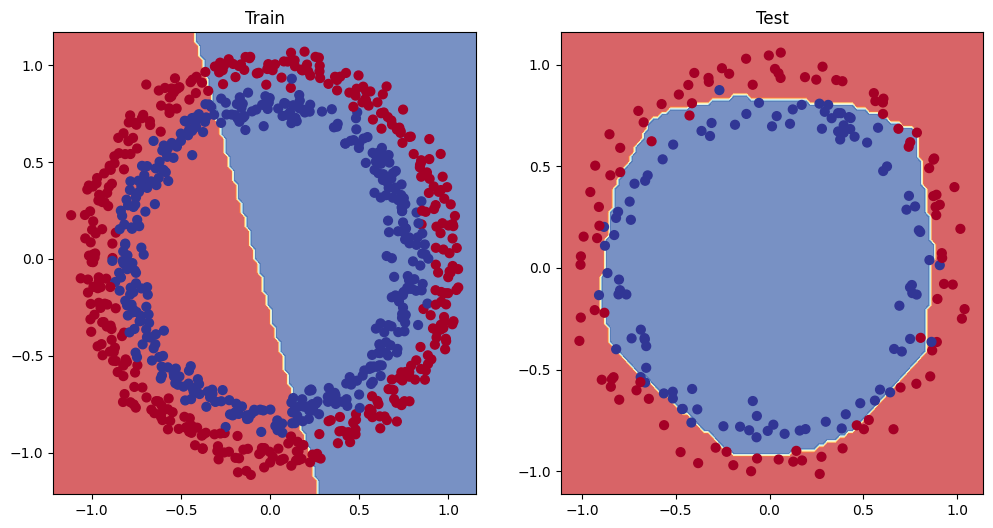

In [13]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(modelV0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity


On the left we have our first linear model , and on the right we have our model with non linearity. We see that adding the ReLU activation function allows the model to capture the non linear nature of the circles. 

## Multi-class pytorch models

Now that we have convered the basics for binary classifations, we will put it all together and build a multi-class classifcation problem. We will go through the usual process
* Prepare data
* Build model
* Train model
* Make predictions

For our data we will use scikit-learns make_blobs(), which you could also classify using clustering techniques.

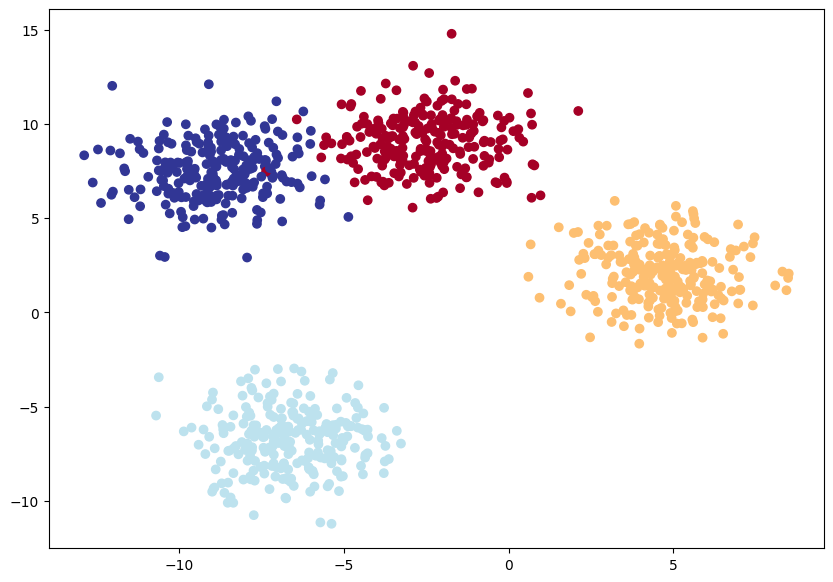

In [43]:
from sklearn.datasets import make_blobs


NUM_CLASSSES = 4
NUM_FEATURES =2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples= 1000, n_features = NUM_FEATURES,centers= NUM_CLASSSES, cluster_std = 1.5, random_state= RANDOM_SEED)
X_blob = torch.from_numpy(X_blob).type(torch.float).to(device)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor).to(device)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0].cpu(), X_blob[:, 1].cpu(), c=y_blob.cpu(), cmap=plt.cm.RdYlBu);


To build a model for multiclass classification we will want to have 4 outputs, each output relating to a class. Our choice of loss function for this problem will be cross entropy loss, which is as bit like binary entropy loss but for multiclass classifcaition.

Cross loss entropy works on the logits as the output so there is no need for a softmax (probability) output.

In [47]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSSES, 
                    hidden_units=8).to(device)
model_4

loss_fn_CEL = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1)

Similar to before we will make a training loop for our model, we will also calculate the predictions so that we can calculate the accuracy of our model (true positive / total predictions).

In [48]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn_CEL(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn_CEL(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


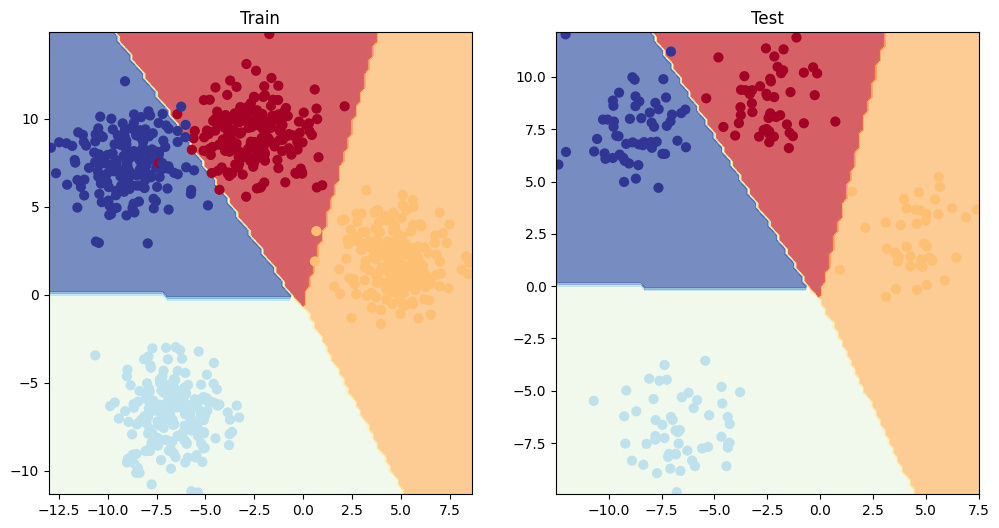

: 

In [49]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

When plotting the decision boundries of our model we see that no non-linearity was needed in the model for it to capture the full nature of the problem.